In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML

pd.set_option('display.max_columns', 100)

## EXTENSION 1

Working with Decision Tree Models to predict important features for permit approval outcomes

To begin, we will load both the approved permits data and the zoning board of appeal data and look at their current columns

In [42]:
zba_main = pd.read_csv('data/cleaned_zba.csv')
abp_main = pd.read_csv('data/cleaned_abp.csv')

zba_main.head()

,status,parent_apno,boa_apno,appeal_type,submitted_date,received_date,hearing_date,ever_deferred,num_deferrals,final_decision_date,decision,closed_date,city,zip,ward,zoning_district,project_description,sd_year,sd_month,sd_day,hd_year,hd_month,hd_day,hearing_submitted,fd_year,fd_month,fd_day,final_submitted,final_hearing,cd_year,cd_month,cd_day,closed_submitted,closed_hearing,closed_final
0,1,NaN,BOA1534017,0,2023-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jamaica Plain,2130,19,Jamaica Plain,NaN,2023,10,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,NaN,BOA1534015,0,2023-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,2131,19,Jamaica Plain,NaN,2023,10,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,ALT1486864,BOA1533753,0,2023-10-06,2023-10-06,NaN,NaN,NaN,NaN,NaN,NaN,East Boston,2128,1,East Boston,Change Occupancy 2 family to 3 Extend living s...,2023,10,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,ALT1527237,BOA1533784,0,2023-10-06,2023-10-06,NaN,NaN,NaN,NaN,NaN,NaN,Brighton,2135,21,Allston/Brighton,change Occupancy from 2 family to 3 add bathro...,2023,10,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,ERT1515294,BOA1533227,0,2023-10-05,2023-10-05,NaN,NaN,NaN,NaN,NaN,NaN,Roslindale,2131,20,Roslindale,Building new 2 family duplex home Market rate ...,2023,10,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
abp_main.head()

,object_id,permitnumber,worktype,permittypedescr,description,comments,declared_valuation,total_fees,issued_date,expiration_date,status,occupancytype,sq_feet,city,zip,property_id,parcel_id,lat,long,issued_year,issued_month,issued_day,expiration_year,expiration_month,expiration_day
0,1,A1000569,INTEXT,Amendment to a Long Form,Interior/Exterior Work,This work is to Amend Permit ALT347244. Elimin...,36500.00,390.0,2021-01-28,2021-07-28,Open,Mixed,0.0,Boston,2109.0,130392.0,3.038070e+08,42.359190,-71.052924,2021,1,28,2021.0,7.0,28.0
1,2,A100071,COB,Amendment to a Long Form,City of Boston,Change connector link layout from attached enc...,40000.00,429.0,2011-11-04,2012-05-04,Open,Comm,170.0,West Roxbury,2132.0,17268.0,2.012032e+09,42.260750,-71.149611,2011,11,4,2012.0,5.0,4.0
2,3,A1001012,OTHER,Amendment to a Long Form,Other,Amend Alt943748 to erect a roof deck as per pl...,5000.00,70.0,2020-06-01,NaN,Open,1-3FAM,0.0,Charlestown,2129.0,113443.0,2.028370e+08,42.375243,-71.057585,2020,6,1,NaN,NaN,NaN
3,4,A1001201,INTEXT,Amendment to a Long Form,Interior/Exterior Work,Build steel balcony over garden level with sta...,74295.75,803.0,2019-11-13,2020-05-13,Closed,Multi,0.0,Roxbury,2118.0,129994.0,4.025580e+08,42.340600,-71.080251,2019,11,13,2020.0,5.0,13.0
4,5,A100137,EXTREN,Amendment to a Long Form,Renovations - Exterior,Landscaping/stonework - amending permit #2801/...,15000.00,206.0,2013-01-03,2013-07-03,Open,1-2FAM,0.0,Brighton,2135.0,149852.0,2.204944e+09,42.344600,-71.154051,2013,1,3,2013.0,7.0,3.0


Prior knowledge tells us that parent_apno and permitnumber correlate, but let's gather some more basic info about the two datasets before we make decisions on what columns to drop. First we will analyze the details of the data (for example null value counts), and then drop columns based on intuition and past findings.

In [11]:
def analyze_table(table: pd.DataFrame):
  column_names = ['col_name', 'num_null', 'col_data_type', 'col_is_numeric', 'num_duplicates']
  prim_anal = pd.DataFrame(columns=column_names)
  table.copy().apply(lambda x: analyze_col(x, prim_anal), axis=0)
  return prim_anal

def analyze_col(col: pd.Series, table: pd.DataFrame):
  arr = [
      str(col.name),
      str(col.isnull().sum()),
      str(set(type(x) for x in col.values)),
      str(np.issubdtype(col.dtype, np.number)),
      str(col.duplicated(keep='first').sum())
  ]
  table.loc[len(table)] = arr

styles = [
    {'background-color': 'lightcoral', 'color': 'white'},  # Red
    {'background-color': 'lightblue', 'color': 'white'},   # Blue
]
df1, df2 = (analyze_table(abp_main), analyze_table(zba_main))
result = pd.concat([df1, df2], axis=1)

styled_dfs = [
    df.style.set_table_styles([
        {'selector': 'thead', 'props': [('background-color', styles[i]['background-color'])]},
        {'selector': 'th', 'props': [('color', styles[i]['color'])]},
        {'selector': 'tbody', 'props': [('background-color', 'white')]},
        {'selector': 'td', 'props': [('color', 'black')]}
    ]) for i, df in enumerate([df1, df2])
]

# Display the dataframes side by side
for styled_df in styled_dfs:
    display(styled_df)

del df1, df2

,col_name,num_null,col_data_type,col_is_numeric,num_duplicates
0,object_id,0,{},True,0
1,permitnumber,0,{},False,47938
2,worktype,4554,"{, }",False,622197
3,permittypedescr,0,{},False,622262
4,description,4554,"{, }",False,622198
5,comments,210,"{, }",False,152159
6,declared_valuation,0,{},True,565615
7,total_fees,0,{},True,597788
8,issued_date,0,{},False,617807
9,expiration_date,25094,"{, }",False,617648


,col_name,num_null,col_data_type,col_is_numeric,num_duplicates
0,status,0,{},True,9033
1,parent_apno,269,"{, }",False,609
2,boa_apno,0,{},False,0
3,appeal_type,0,{},True,9038
4,submitted_date,0,{},False,6707
5,received_date,524,"{, }",False,6860
6,hearing_date,1166,"{, }",False,8704
7,ever_deferred,1166,"{, }",False,9037
8,num_deferrals,1166,{},True,9032
9,final_decision_date,751,"{, }",False,8431


In [43]:
zba_main = zba_main[['parent_apno','appeal_type', 'decision', 'city', 'zip', 'ward', 'zoning_district', 'project_description', 'sd_year', 'sd_month', 'sd_day', 'hearing_submitted']]
abp_main = abp_main[['permitnumber', 'worktype', 'permittypedescr', 'description', 'comments', 'declared_valuation', 'total_fees', 'status', 'occupancytype', 'sq_feet', 'city', 'zip', 'property_id', 'parcel_id', 'lat', 'long', 'issued_year', 'issued_month', 'issued_day']]

In [28]:
zba_main.head()

,parent_apno,appeal_type,decision,city,zip,ward,zoning_district,project_description,sd_year,sd_month,sd_day,hearing_submitted
0,NaN,0,NaN,Jamaica Plain,2130,19,Jamaica Plain,NaN,2023,10,7,0
1,NaN,0,NaN,Roslindale,2131,19,Jamaica Plain,NaN,2023,10,7,0
2,ALT1486864,0,NaN,East Boston,2128,1,East Boston,Change Occupancy 2 family to 3 Extend living s...,2023,10,6,0
3,ALT1527237,0,NaN,Brighton,2135,21,Allston/Brighton,change Occupancy from 2 family to 3 add bathro...,2023,10,6,0
4,ERT1515294,0,NaN,Roslindale,2131,20,Roslindale,Building new 2 family duplex home Market rate ...,2023,10,5,0


In [29]:
abp_main.head()

,permitnumber,worktype,permittypedescr,description,comments,declared_valuation,total_fees,status,occupancytype,sq_feet,city,zip,property_id,parcel_id,lat,long,issued_year,issued_month,issued_day
0,A1000569,INTEXT,Amendment to a Long Form,Interior/Exterior Work,This work is to Amend Permit ALT347244. Elimin...,36500.00,390.0,Open,Mixed,0.0,Boston,2109.0,130392.0,3.038070e+08,42.359190,-71.052924,2021,1,28
1,A100071,COB,Amendment to a Long Form,City of Boston,Change connector link layout from attached enc...,40000.00,429.0,Open,Comm,170.0,West Roxbury,2132.0,17268.0,2.012032e+09,42.260750,-71.149611,2011,11,4
2,A1001012,OTHER,Amendment to a Long Form,Other,Amend Alt943748 to erect a roof deck as per pl...,5000.00,70.0,Open,1-3FAM,0.0,Charlestown,2129.0,113443.0,2.028370e+08,42.375243,-71.057585,2020,6,1
3,A1001201,INTEXT,Amendment to a Long Form,Interior/Exterior Work,Build steel balcony over garden level with sta...,74295.75,803.0,Closed,Multi,0.0,Roxbury,2118.0,129994.0,4.025580e+08,42.340600,-71.080251,2019,11,13
4,A100137,EXTREN,Amendment to a Long Form,Renovations - Exterior,Landscaping/stonework - amending permit #2801/...,15000.00,206.0,Open,1-2FAM,0.0,Brighton,2135.0,149852.0,2.204944e+09,42.344600,-71.154051,2013,1,3


- Deferrals were mostly 0 or none


## Decision Tree

Since the ZBA dataset is significantly smaller than the abp dataset, it means the number of approved permits vastly outnumbers the number of initially denied permits and certainly the number of zba denied permits. To circumvent this, we will initially interpret the zba dataset as denied permits and then randomly sample the abp dataset to ensure the decision trees we generate are balanced. We will also make sure our data is from the same time frame. Our final data should be around 16000 minimum entries

In [57]:
# we will look at the other columns later, but for now we will just use the text columns

# process the id columns so that we can make sure that we aren't merging duplicates
abp_main['permitnumber'] = abp_main['permitnumber'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
zba_main['parent_apno'] = zba_main['parent_apno'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
apnos = list(zba_main['parent_apno']) # to ensure no approved values that went through zba


# filter out unwanted rows and get text columns
zba_temp = zba_main[zba_main['sd_year'] > 2014] # match min date to abp
zba_temp = pd.DataFrame({'text': zba_temp['project_description'], 'approved': False})

abp_temp = abp_main[~abp_main['permitnumber'].isin(apnos)]
abp_temp = abp_temp.sample(n=9000, random_state=42) # sample to get balanced data
abp_temp = pd.DataFrame({'text': abp_temp['comments'], 'approved': True})

merged_df = pd.concat([abp_temp, zba_temp], ignore_index=True)
merged_df.sample(10)


,text,approved
11917,COMBINE PARCELS 274 2727 ERECT NEW 2 1 STORY F...,False
12699,TAKE PART PARCEL 2968 000 CREATE THIS NEW LOT ...,False
12046,Four story twenty unit affordable condo buildi...,False
4081,plumbing remodeling,True
12795,Full interior renovation to existing three fam...,False
1393,gas clothes dryer,True
2087,Renovate bathroom in Unit 1,True
8477,REHAB OF APARTMENT #19 NEW BATHROOM FINISHES ...,True
15936,“To erect new story residential building groun...,False
12689,Change occupancy from tenants store to Lodging...,False


In [79]:
def process_string(input_string):
    # Remove non-alphabetical characters (excluding whitespace) using regex
    only_alphabetical = re.sub(r'[^a-zA-Z\s]', '', str(input_string))
    
    # Convert all words to lowercase
    lowercase_result = only_alphabetical.lower()
    
    return lowercase_result

# Example
merged_df.text = merged_df.text.apply(process_string)

In [81]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stop words list (if not already downloaded)
nltk.download('stopwords')

# Tokenize the string into words
def remove_stopwords(sample_string):
    words = word_tokenize(sample_string)
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(filtered_words)

merged_df.text = merged_df.text.apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
merged_df.sample(10)

,text,approved
6149,rewire two family home new amp service,True
6341,hotel wireless communications health club offi...,True
9689,addition per stamped drawings eplan gt boa,False
7113,add navien water heaters gas furnaces,True
16085,change occupancy beauty salon restaurant takeo...,False
151,select demolition work conjuction alt,True
2862,remodel two bathrooms add laundry connection m...,True
4630,demolition old car port,True
4451,bwh acnn replacement francis street misc low v...,True
1094,new service,True


Now we can train our decision tree models

Accuracy: 0.79
              precision    recall  f1-score   support

       False       0.92      0.61      0.73      1598
        True       0.73      0.95      0.83      1810

    accuracy                           0.79      3408
   macro avg       0.83      0.78      0.78      3408
weighted avg       0.82      0.79      0.78      3408



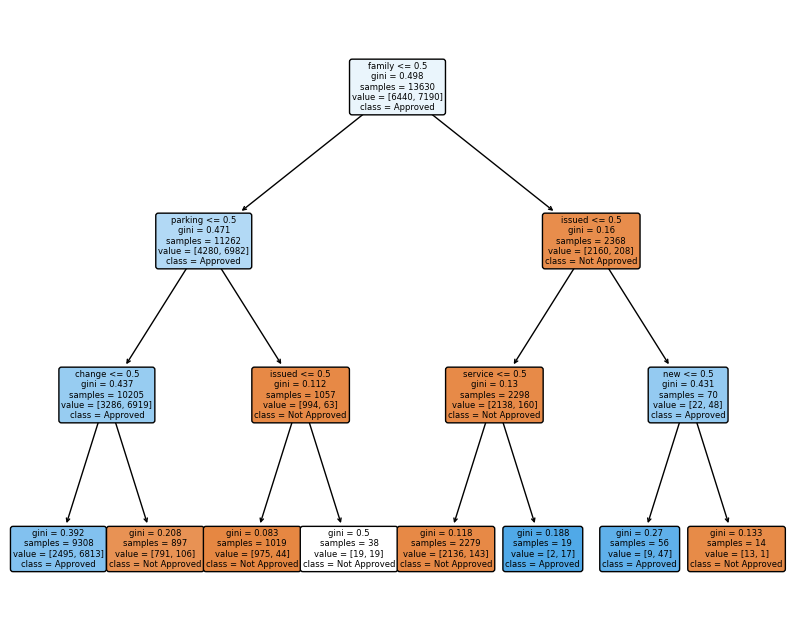

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your DataFrame with 'text_column' and 'approved_column'
# Replace 'df', 'text_column', and 'approved_column' with your actual DataFrame and column names

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(merged_df['text'], merged_df['approved'], test_size=0.2, random_state=42)

# Vectorize the text data (convert text into numerical features)
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Create a Decision Tree model
model = DecisionTreeClassifier(max_depth = 3, random_state=52)

# Train the model on the training data
model.fit(X_train_vectorized, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
plot_tree(model, filled=True, feature_names=list(vectorizer.get_feature_names_out()), class_names=['Not Approved', 'Approved'], rounded=True)
plt.show()